In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json

import sys
sys.path.append("../")
from ritini.data_generation.toy_data import create_temporal_graph_data
from ritini.models.gat import TemporalGAT
from ritini.data.temporal_graph import TemporalGraphDataset
from ritini.train import train_epoch

In [2]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data parameters
n_timepoints = 20
n_trajectories = 2
n_genes = 10
batch_size = 4
time_window = 5  # Length of time_window, set to None to use all timepoints
n_change = 5

# Training parameters
n_epochs = 100
learning_rate = 0.001
n_heads = 1
hidden_features = 32
dropout = 0.1

#Scheduler configs
lr_factor = 0.5
lr_patience = 10

# Create temporal graph data with slow edge changes
all_node_features, all_graphs = create_temporal_graph_data(
    n_timepoints=n_timepoints,
    n_trajectories=n_trajectories,
    n_genes=n_genes,
    edge_density=0.3,
    temporal_noise=0.1,
    save= False,
)

# Select a single trajectory type for training
trajectory_idx = 0
train_node_features = all_node_features[trajectory_idx]  # Shape: (n_timepoints, n_genes)
train_graphs = all_graphs[trajectory_idx]  # List of n_timepoints graphs

# Extract prior graph (initial graph at t=0)
prior_graph = train_graphs[0]

# Convert prior graph to adjacency matrix
prior_adjacency = torch.zeros(n_genes, n_genes)
for edge in prior_graph.edges():
    prior_adjacency[edge[0], edge[1]] = 1
    prior_adjacency[edge[1], edge[0]] = 1  # Symmetric

print(f"\nPrior graph (t=0): {len(prior_graph.nodes())} nodes, {len(prior_graph.edges())} edges")
print(f"Prior adjacency shape: {prior_adjacency.shape}\n")


Using device: cpu

Prior graph (t=0): 10 nodes, 11 edges
Prior adjacency shape: torch.Size([10, 10])



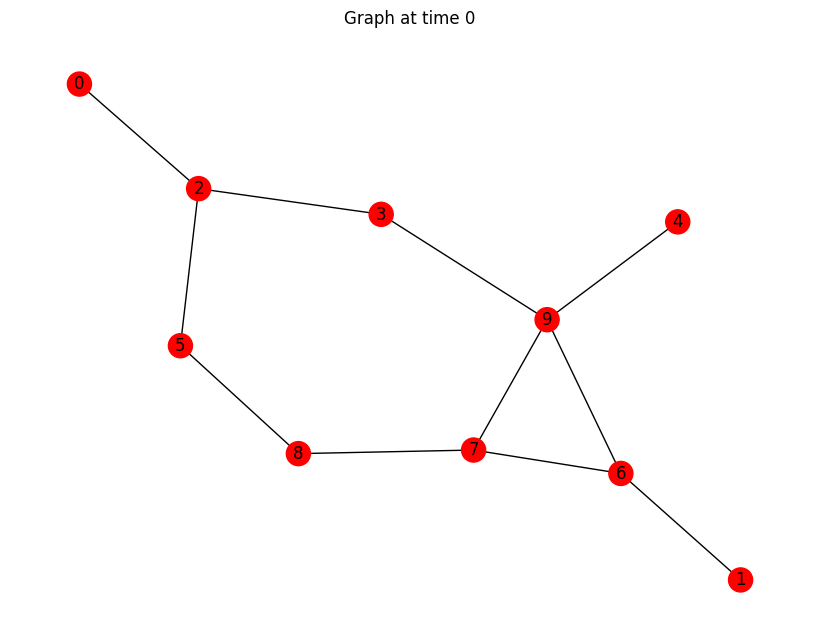

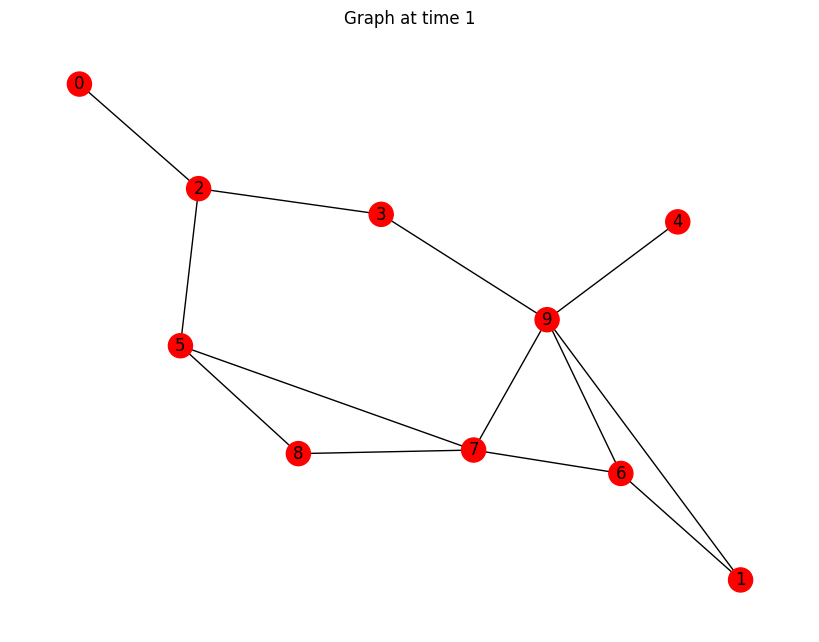

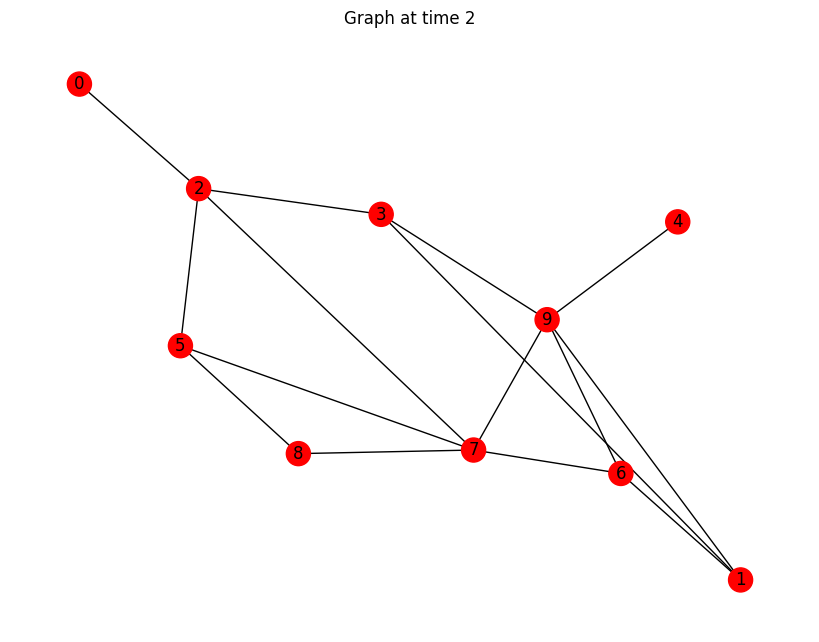

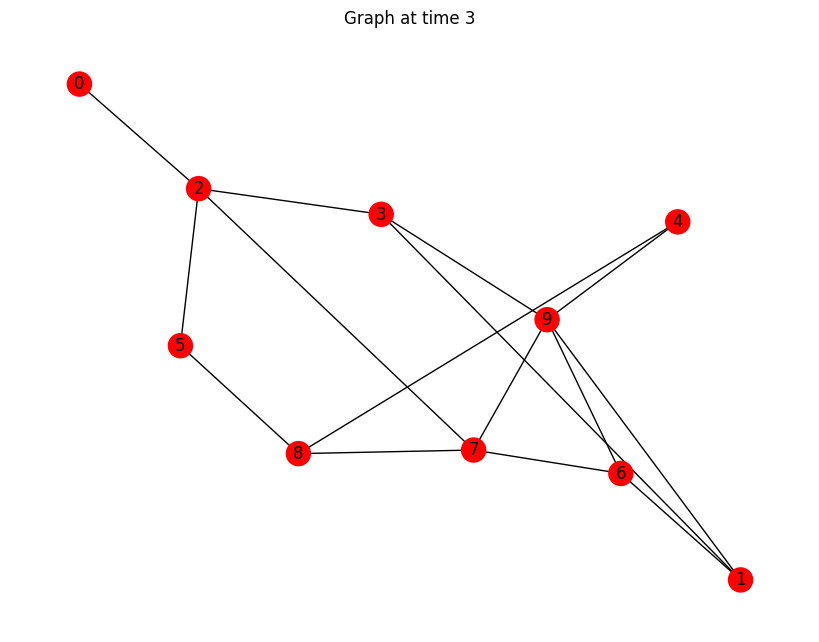

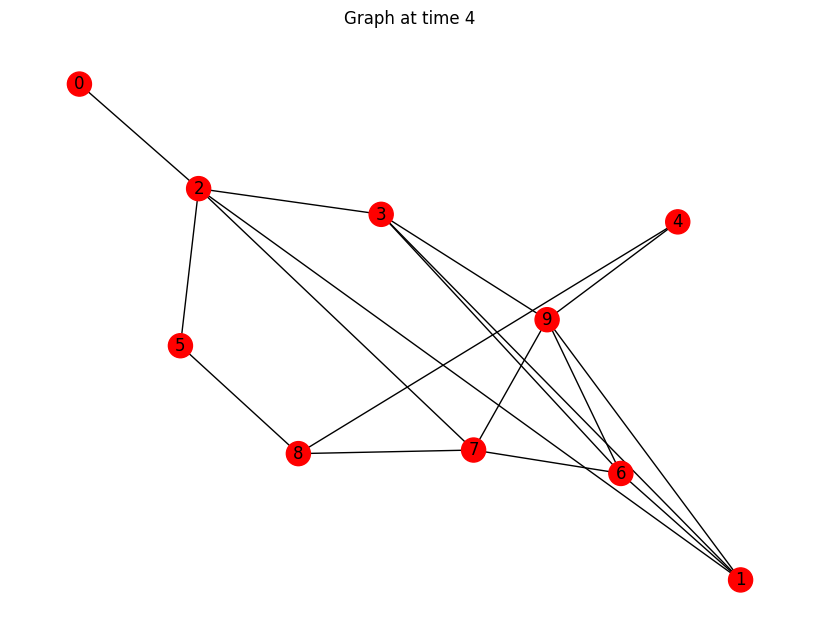

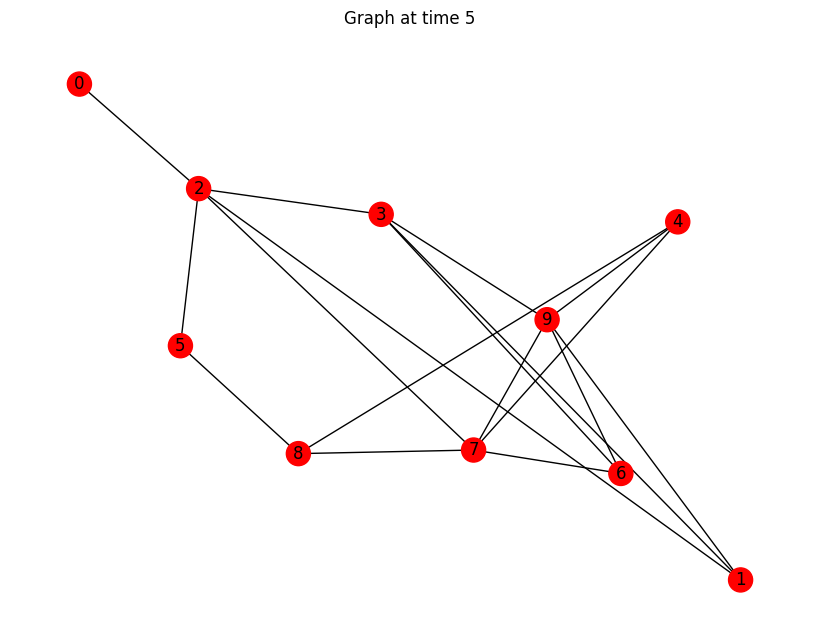

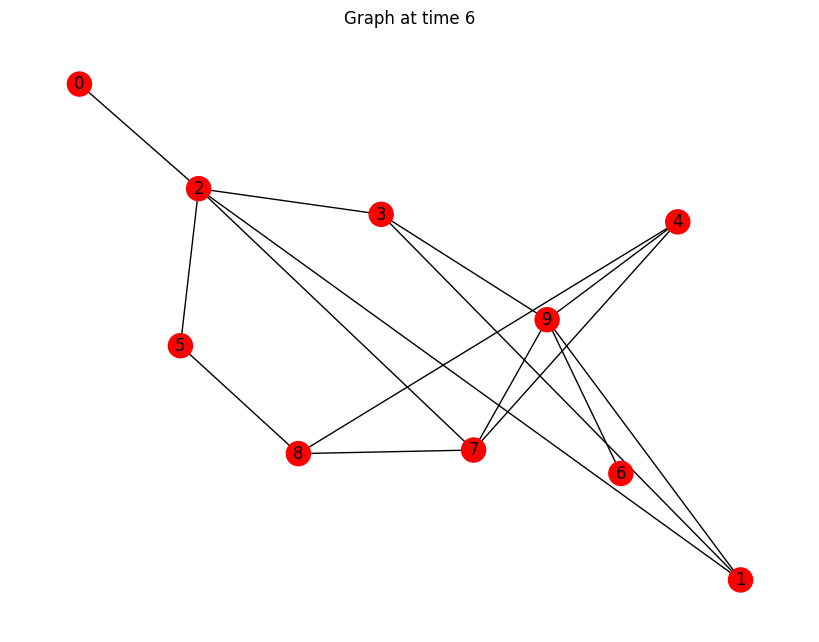

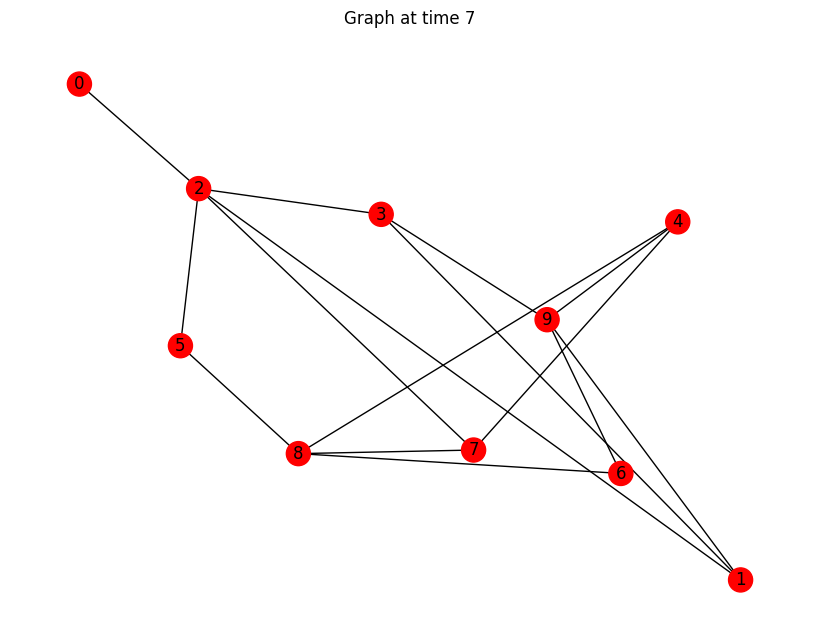

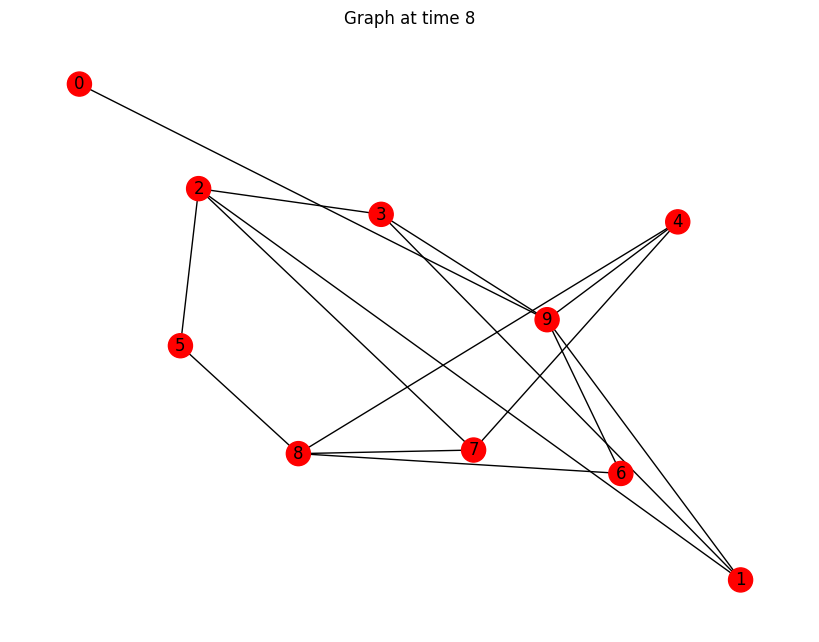

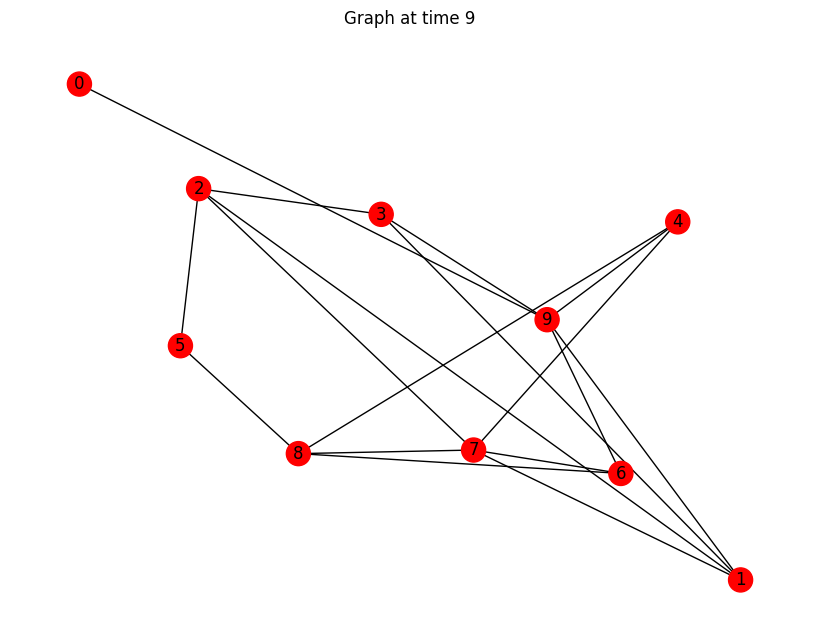

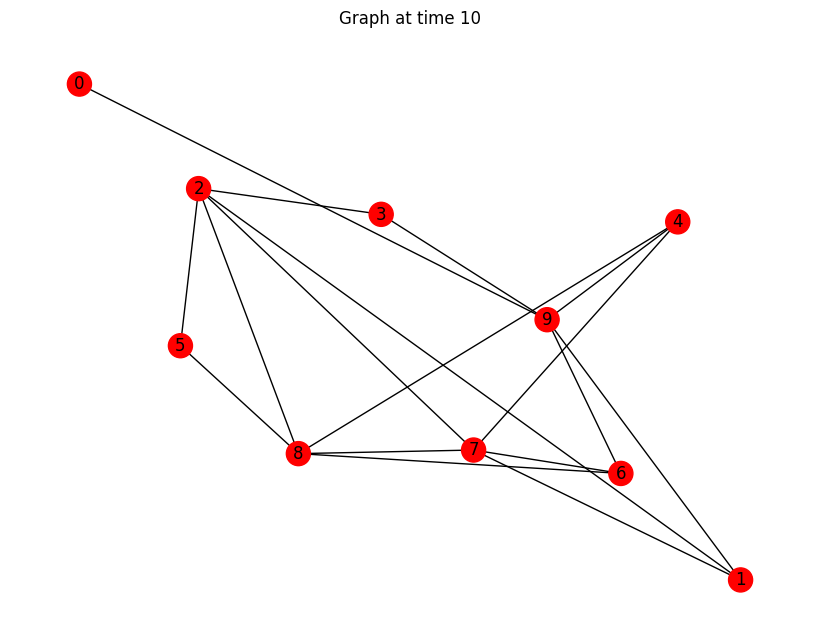

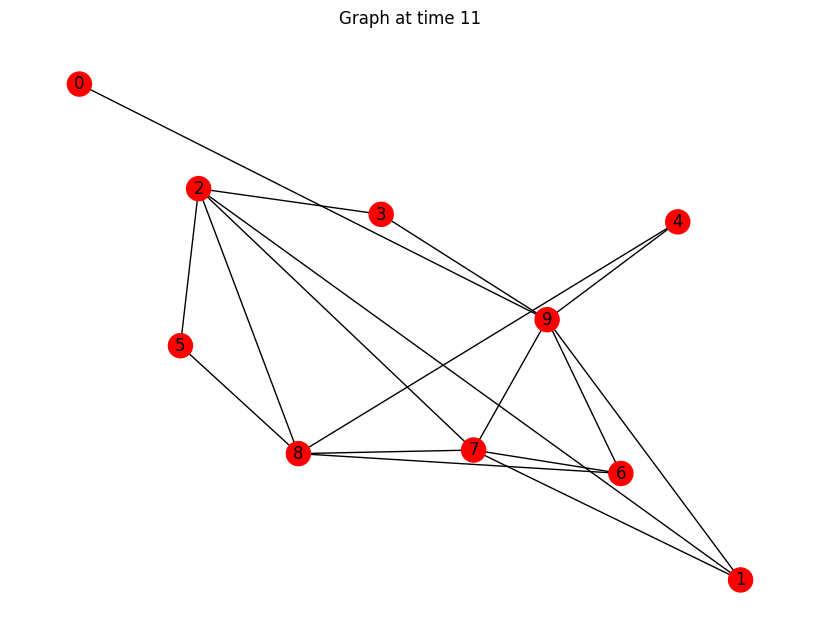

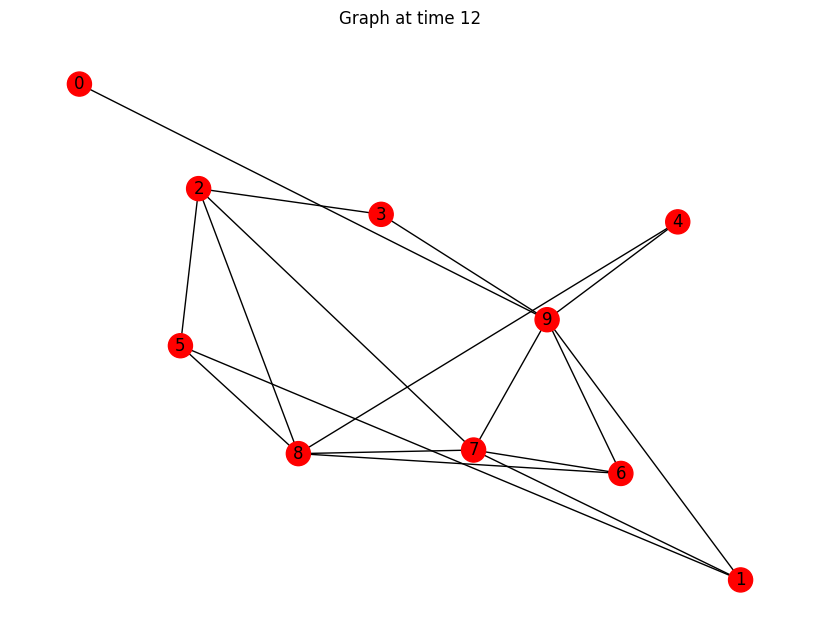

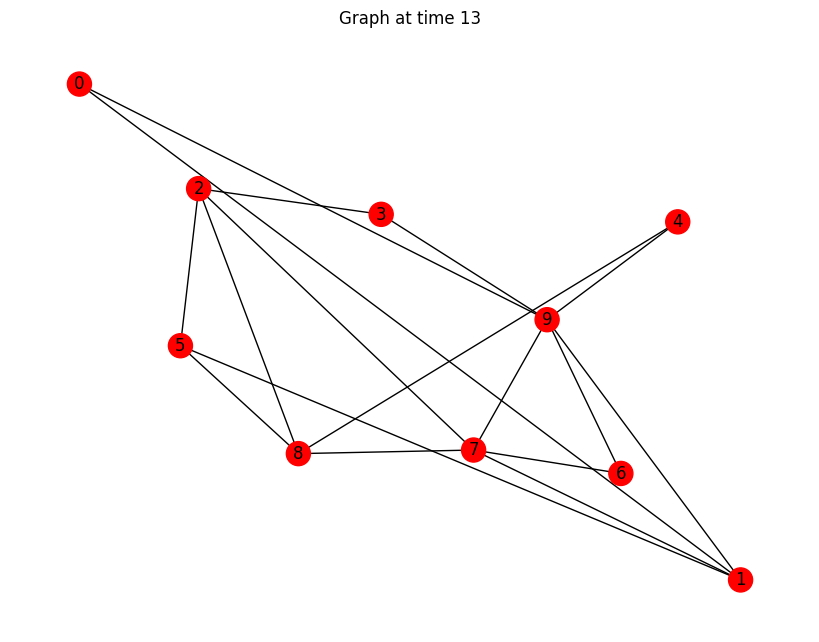

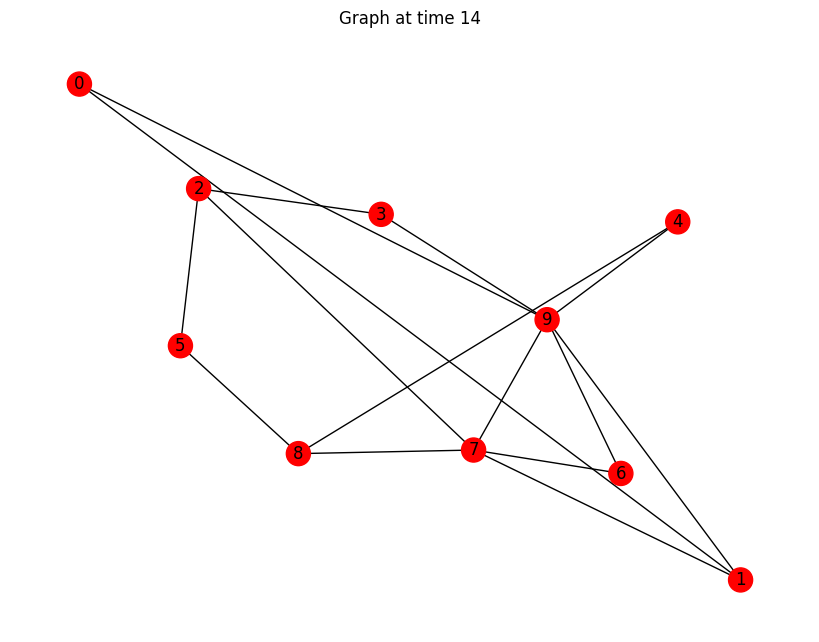

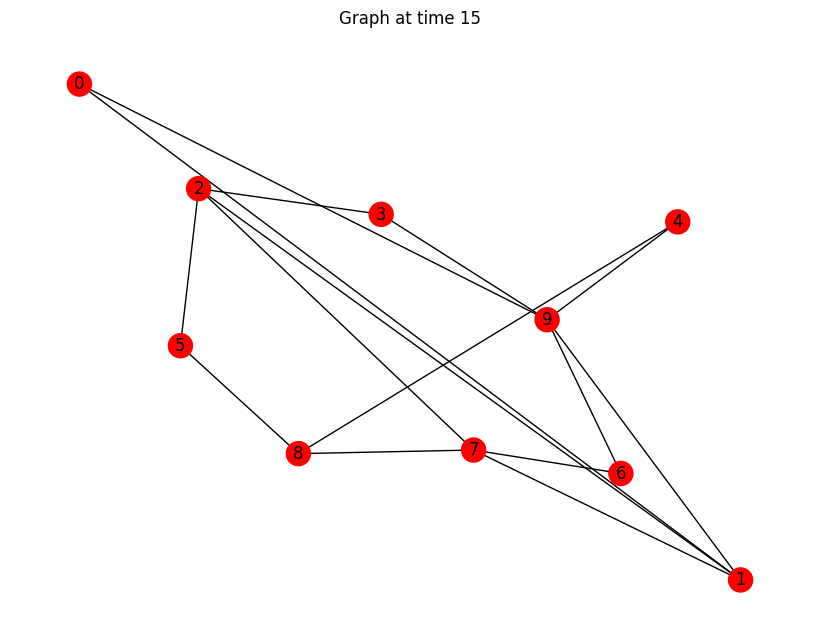

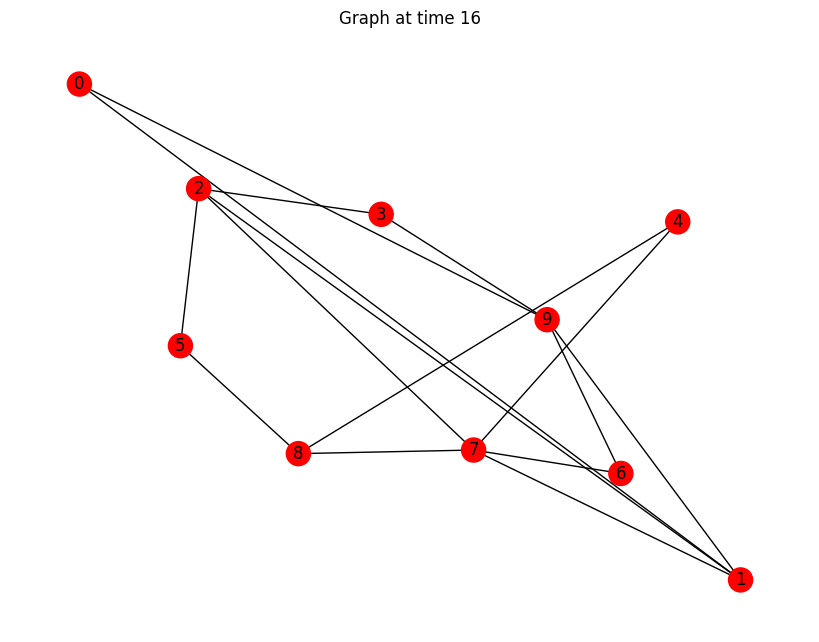

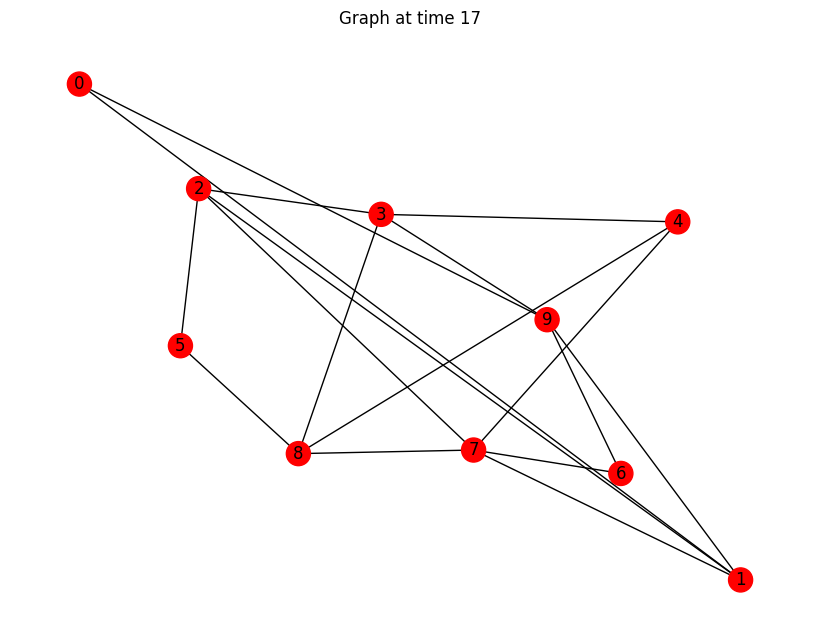

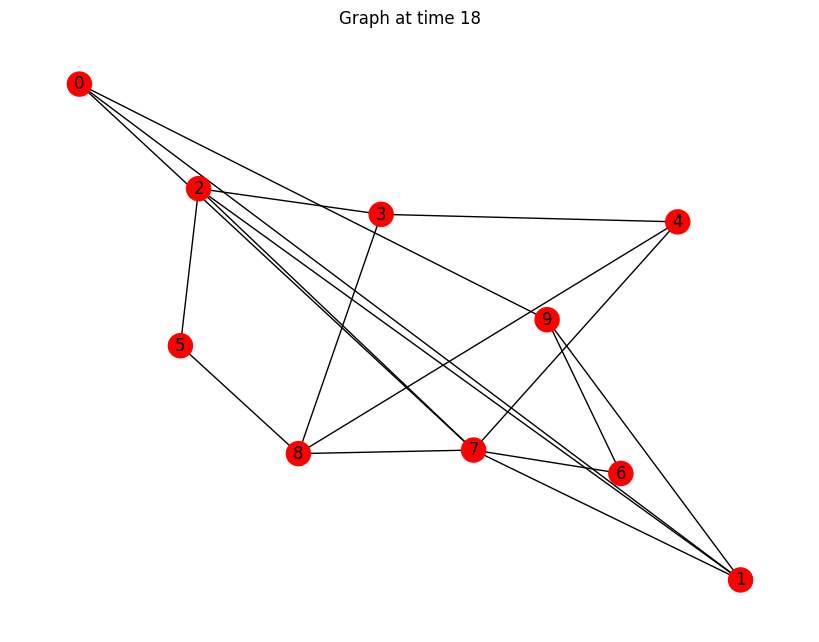

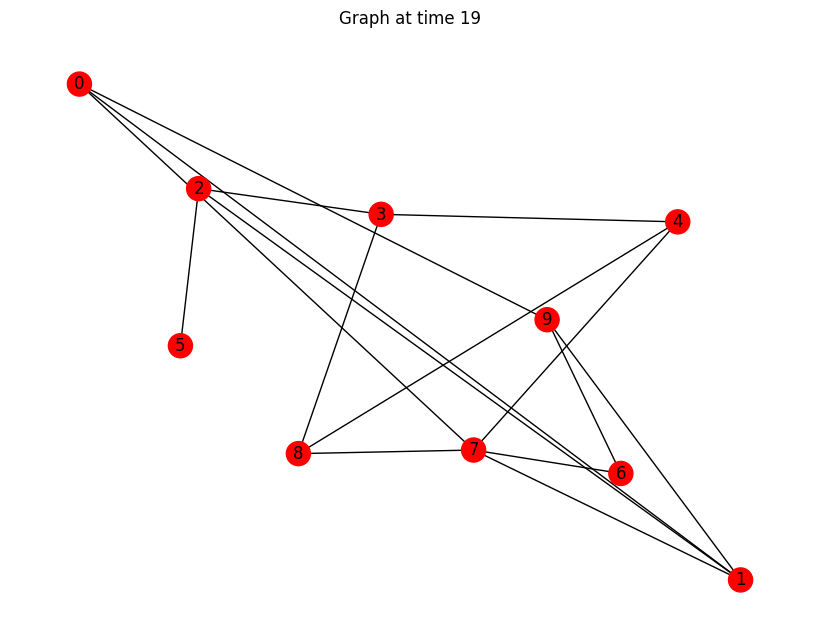

In [7]:
# Example structure
import networkx as nx
import matplotlib.pyplot as plt
seed=42
pos = nx.spring_layout(prior_graph.to_undirected(), seed=seed)

for t, graph in enumerate(all_graphs[trajectory_idx]):
    plt.figure(figsize=(8, 6))
    
    # Identify nodes in prior_graph
    prior_nodes = set(prior_graph.nodes())
    current_nodes = set(graph.nodes())
    
    # Color nodes differently
    node_colors = ['red' if node in prior_nodes else 'blue' 
                   for node in graph.nodes()]
    
    nx.draw(graph,pos=pos, node_color=node_colors, with_labels=True)
    plt.title(f'Graph at time {t}')
    plt.show()

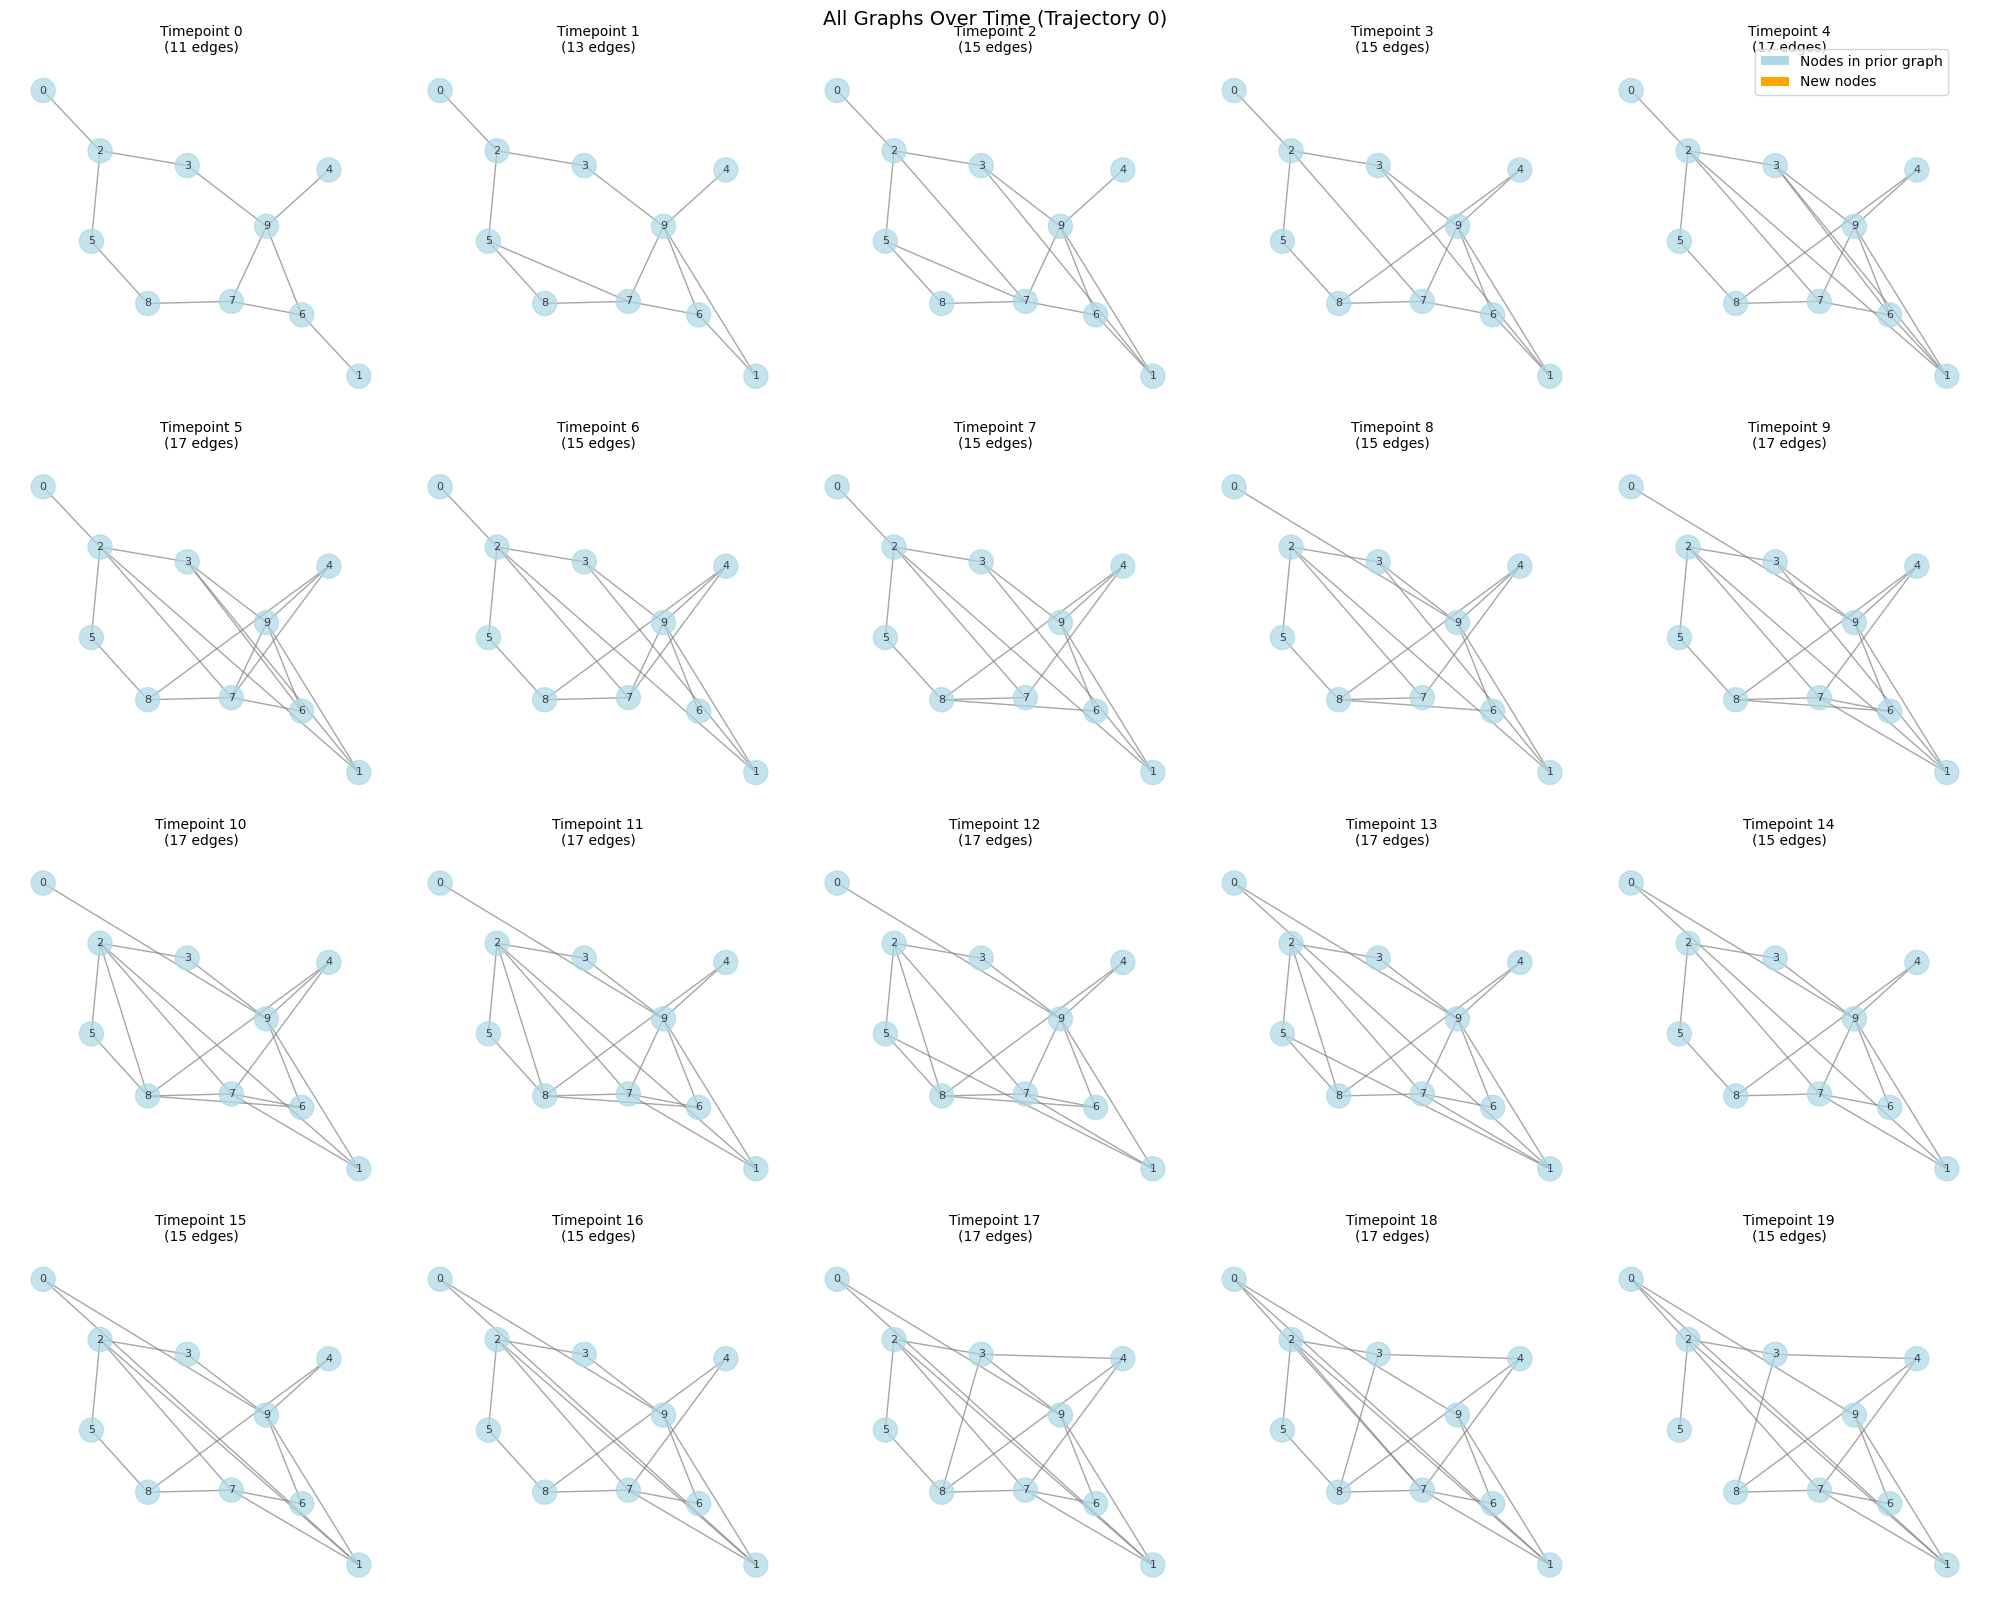

In [8]:
import matplotlib.pyplot as plt

# Get prior graph nodes for reference
prior_nodes = set(prior_graph.nodes())

# Calculate grid dimensions for subplots
n_cols = 5  # Number of columns in the plot grid
n_rows = (n_timepoints + n_cols - 1) // n_cols  # Calculate rows needed

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_timepoints > 1 else [axes]

# Use fixed layout based on first graph for easier comparison
pos = nx.spring_layout(train_graphs[0], seed=42)

# Plot each timepoint
for t in range(n_timepoints):
    G = train_graphs[t]
    ax = axes[t]
    
    # Determine node colors based on whether they're in prior_graph
    node_colors = []
    for node in G.nodes():
        if node in prior_nodes:
            node_colors.append('lightblue')  # Nodes in prior_graph
        else:
            node_colors.append('orange')  # New nodes not in prior_graph
    
    # Draw the graph
    nx.draw(
        G,
        pos=pos,
        ax=ax,
        node_color=node_colors,
        node_size=300,
        with_labels=True,
        font_size=8,
        edge_color='gray',
        alpha=0.7,
        arrows=False
    )
    
    ax.set_title(f'Timepoint {t}\n({len(G.edges())} edges)', fontsize=10)

# Hide unused subplots
for t in range(n_timepoints, len(axes)):
    axes[t].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', label='Nodes in prior graph'),
    Patch(facecolor='orange', label='New nodes')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.suptitle(f'All Graphs Over Time (Trajectory {trajectory_idx})', fontsize=14, y=1.00)
plt.show()